In [569]:
import matplotlib.pyplot as plt
from tqdm import tqdm

import pandas as pd

import seaborn as sns
import numpy as np

In [570]:
class Water:
    def __init__(self, volume=0.0, NH4=0.0, NO3=0.0, bzv=0.0, O2=0.0):
        self.volume = volume # m3
        self.NH4 = NH4  # mg/l
        self.NO3 = NO3  # mg/l
        self.bzv = bzv  # mg/l
        self.O2 = O2  # mg/l

        self.NH4_absoluut = (self.NH4 * (self.volume*1000))  # mg
        self.NO3_absoluut = (self.NO3 * (self.volume*1000))  # mg
        self.bzv_absoluut = (self.bzv * (self.volume*1000))  # mg
        self.O2_absoluut = (self.O2 * (self.volume*1000))  # mg

    def update_NH4(self, NH4):
        self.NH4 = NH4  # mg/l
        self.NH4_absoluut = (self.NH4 * (self.volume*1000))  # mg
        
    def update_NO3(self, NO3):
        self.NO3 = NO3  # mg/l
        self.NO3_absoluut = (self.NO3 * (self.volume*1000))  # mg

    def update_bzv(self, bzv):
        self.bzv = bzv  # mg/l
        self.bzv_absoluut = (self.bzv * (self.volume*1000))  # mg

    def update_O2(self, O2):
        self.O2 = O2  # mg/l
        self.O2_absoluut = (self.O2 * (self.volume*1000))  # mg
    
    def get_absoluut(self):
        '''
        returns
            volume 
                m3
            NH4
                mg
            NO3
                mg
            bzv
                mg
            O2
                mg
        '''
        return self.volume, self.NH4_absoluut, self.NO3_absoluut, self.bzv_absoluut, self.O2_absoluut
    
    def __str__(self):
        return "Volume = {:.1f}m3\tNH4 = {:.4f}mg/l\tNO3 = {:.4f}mg/l\tvaste_stof = {:.4f}mg/l".format(self.volume, self.NH4, self.NO3, self.bzv)

In [571]:
class Influent(Water):
    def __init__(self, volume=0.0, NH4=0.0, NO3=0.0, bzv=850, O2=0.0):
        super().__init__(volume=volume, NH4=NH4, NO3=NO3, bzv=bzv, O2=O2)

In [572]:
class Tank(Water):
    def __init__(self, volume=0.0, NH4=0.0, NO3=0.0, bzv=0.0, O2=0.0):
        super().__init__(volume=volume, NH4=NH4, NO3=NO3, bzv=bzv, O2=O2)

        self.volume_tank = volume

In [573]:
class AnoxischeTank(Tank):
    def __init__(self, volume=1440, NH4=0.0, NO3=0.0, bzv=0.0, denitrificatiesnelheid=100000):
        super().__init__(volume=volume, NH4=NH4, NO3=NO3, bzv=bzv)
        
        self.denitrificatiesnelheid = denitrificatiesnelheid  # mg/s
        
        self.molverhouding_bzv_n = 0.86#5.16  # 1 mol bzv = 12.01070 g 1 mol no3 = 62.0049g, 1 mol n = 14.00670g

    def step(self, water_influent, water_recirculatie, t=900):
        volume_influent, NH4_influent, NO3_influent, bzv_influent, _ = water_influent.get_absoluut()
        volume_recirculatie, NH4_recirculatie, NO3_recirculatie, bzv_recirculatie, _ = water_recirculatie.get_absoluut()

        volume_tank, NH4_tank, NO3_tank, bzv_tank, _ = self.get_absoluut()

        volume_tot = volume_influent + volume_recirculatie + volume_tank  # m3
        NH4_tot = NH4_influent + NH4_recirculatie + NH4_tank  # mg
        NO3_tot = NO3_influent + NO3_recirculatie + NO3_tank  # mg
        bzv_tot = bzv_influent + bzv_recirculatie + bzv_tank  # mg
        
        # denitrificatie
        #2NO3 + 4H + bzv(2c) --> N2 + 2H2O + 2CO2
        NO3_verlies = min(self.denitrificatiesnelheid * t, NO3_tot, bzv_tot/self.molverhouding_bzv_n)  # mg
        bzv_verlies = self.molverhouding_bzv_n * NO3_verlies  # mg

        NO3_tot = NO3_tot - NO3_verlies  # mg
        bzv_tot = bzv_tot - bzv_verlies  # mg

        volume_effluent = volume_tot - self.volume_tank   # m3
        NH4_effluent = (NH4_tot / (volume_tot * 1000))  # mg/l
        NO3_effluent = (NO3_tot / (volume_tot * 1000))  # mg/l
        bzv_effluent = (bzv_tot / (volume_tot * 1000))  # mg/l

        water_effluent = Water(volume=volume_effluent, NH4=NH4_effluent, NO3=NO3_effluent, bzv=bzv_effluent)

        self.update_NH4(NH4_tot / (volume_tot * 1000))  # mg/l
        self.update_NO3(NO3_tot / (volume_tot * 1000))  # mg/l
        self.update_bzv(bzv_tot / (volume_tot * 1000))  # mg/l


        return water_effluent, NO3_verlies

In [574]:
class Beluchtingstank(Tank):
    def __init__(self, volume=960, NH4=0.0, NO3=0.0, O2=0.0, bzv=0.0, nitrificatiesnelheid=5500, bzv_snelheid=100):
        super().__init__(volume=volume, NH4=NH4, NO3=NO3, O2=O2, bzv=bzv)
        self.nitrificatiesnelheid = nitrificatiesnelheid  # mg/s
        self.bzv_snelheid = bzv_snelheid # self.nitrificatiesnelheid/10#/0.1  # mg/s

        self.o2_per_kwh = 2500000  # mg/kWh
        self.recirculatie_rendement = 800  # m3/kWh

        self.molverhouding_N_2O2 = 4.57#3.55 # 1 mol NH4 = 18.03846 g, 2 mol O2 = 63.99760 g, 1 mol N = 14.00670 g
        self.molverhouding_bzv_O2 = 2.66  # 1 mol bzv = 12.01070 g 1 mol O2 = 31.99880 g
        self.molverhouding_N_N = 1.00#3.44  # 1 mol NH4 = 18.03846 g, 1 mol no3 = 62.0049g, 1 mol N = 14.00670 g
        

    def step(self, water_influent, beluchting, recirculatie, t=900):
        volume_influent, NH4_influent, NO3_influent, bzv_influent, O2_influent = water_influent.get_absoluut()
        volume_tank, NH4_tank, NO3_tank, bzv_tank, O2_tank = self.get_absoluut()

        volume_tot = volume_influent + volume_tank  # m3
        NH4_tot = NH4_influent + NH4_tank  # mg
        NO3_tot = NO3_influent + NO3_tank  # mg
        bzv_tot = bzv_influent + bzv_tank  # mg
        O2_tot = O2_influent + O2_tank  # mg
        
        # beluchting
        O2_tot += (beluchting / 1000) * (t / 3600) * self.o2_per_kwh  # mg
        
        # nitrificatie
        #NH4 + 2O2 --> NO3 + H2O + 2H
        NH4_verlies = min(self.nitrificatiesnelheid * t, NH4_tot, O2_tot/self.molverhouding_N_2O2)  # mg
        O2_verlies = self.molverhouding_N_2O2 * NH4_verlies  # mg
        NO3_winst = self.molverhouding_N_N * NH4_verlies  # mg

        NH4_tot = NH4_tot - NH4_verlies  # mg
        O2_tot = O2_tot - O2_verlies  # mg
        NO3_tot = NO3_tot + NO3_winst  # mg

        # bzv
        #CZV + O2 --> CO2
        bzv_verlies = min(self.bzv_snelheid * t, bzv_tot, O2_tot/self.molverhouding_bzv_O2)  # mg
        O2_verlies = self.molverhouding_bzv_O2 * bzv_verlies  # mg

        bzv_tot = bzv_tot - bzv_verlies  # mg
        O2_tot = O2_tot - O2_verlies  # mg

        volume_recirculatie = min((recirculatie / 1000) * (t / 3600) * self.recirculatie_rendement, volume_tot - self.volume_tank)  # m3

        NH4_recirculatie = (NH4_tot / (volume_tot * 1000))  # mg/l
        NO3_recirculatie = (NO3_tot / (volume_tot * 1000))  # mg/l
        bzv_recirculatie = (bzv_tot / (volume_tot * 1000))  # mg/l

        water_recirculatie = Water(volume=volume_recirculatie, NH4=NH4_recirculatie, NO3=NO3_recirculatie, bzv=bzv_recirculatie)

        volume_effluent = max(volume_tot - volume_recirculatie - self.volume_tank, 0)   # m3
        NH4_effluent = (NH4_tot / (volume_tot * 1000))  # mg/l
        NO3_effluent = (NO3_tot / (volume_tot * 1000))  # mg/l
        bzv_effluent = (bzv_tot / (volume_tot * 1000))  # mg/l

        water_effluent = Water(volume=volume_effluent, NH4=NH4_effluent, NO3=NO3_effluent, bzv=bzv_effluent)

        self.update_NH4(NH4_tot / (volume_tot * 1000))  # mg/l
        self.update_NO3(NO3_tot / (volume_tot * 1000))  # mg/l
        self.update_bzv(bzv_tot / (volume_tot * 1000))  # mg/l
        self.update_O2(O2_tot / (volume_tot * 1000))  # mg/l


        return water_recirculatie, water_effluent, NH4_verlies

In [578]:
recirculatie_w_range = [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 150, 200, 250, 300, 400, 500, 600, 700, 800, 900, 1000, 1250, 1500, 1750, 2000, 2250, 2500, 2750, 3000, 3250, 3500, 3750, 4000, 4250, 4500, 4750, 5000]
print(len(recirculatie_w_range))

37


In [575]:
all_NO3 = list()

df = pd.DataFrame(columns=('influent_nh4', 'influent_volume', 'beluchting', 'recirculatie', 'effluent_eind_Ntot', 't_end'))
i = 0
# w, rw, v_n, v_b, v_d, 

# bij influent = Water(volume=100, NH4=50, bzv=850)
# w_range = [100 * i for i in range(0, 50)]
# r_w_range = [100 * i for i in range(0, 50)]


beluchting_w_range = [1000 * i for i in range(0, 40 + 1)]
recirculatie_w_range = [100 * i for i in range(0, 50 + 1)]


influent_nh4_range = [5 * i for i in range(7, 11 + 1)]
influent_volume_range = [10 * i for i in range(0 + 1, 10 + 1)]

for influent_nh4 in tqdm(influent_nh4_range):
    for influent_volume in influent_volume_range:
        influent = Influent(volume=influent_volume, NH4=influent_nh4)  # influent per kwartier
        for w in beluchting_w_range:
            for r_w in recirculatie_w_range:
                anoxische_tank = AnoxischeTank(volume=1440)
                beluchtingstank = Beluchtingstank(volume=960)

                recirculatie = Water()
                effluent = Water()

                time_range = list(range(1344))  # 1344 kwartier = 2 weken
                previous_ntot = -10000000
                for t in time_range:
                    beluchtingstank_stroom, NO3_verlies = anoxische_tank.step(influent, recirculatie)
                    beluchting_W = w  # W
                    recirculatie_W = r_w  # W
                    recirculatie, effluent, NH4_verlies = beluchtingstank.step(beluchtingstank_stroom, beluchting_W, recirculatie_W)
                    if (effluent.NH4 + effluent.NO3) == previous_ntot:
                        break
                    previous_ntot = effluent.NH4 + effluent.NO3


                df.loc[i] = [influent_nh4, influent_volume, w, r_w, effluent.NH4 + effluent.NO3, t]
                i += 1

# plt.plot(time_range, NO3)
# legend_names.append("NO3")

# plt.plot(time_range, NH4)
# legend_names.append("NH4")

# plt.plot(time_range, bzv)
# legend_names.append("bzv")

# plt.plot(time_range, NH4_verlies_list)
# legend_names.append("NH4 verlies")

# plt.plot(time_range, NO3_verlies_list)
# legend_names.append("NO3 verlies")

# plt.legend(legend_names)



100%|██████████| 1/1 [00:00<00:00,  2.47it/s]


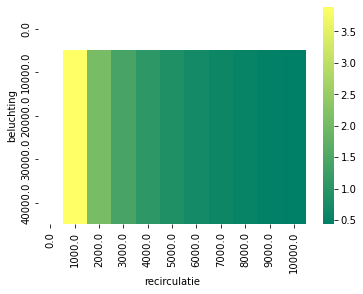

In [576]:
from matplotlib import cm
from matplotlib.colors import ListedColormap

RdYlGn = cm.get_cmap('summer', 256)

newcolors = np.flip(RdYlGn(np.linspace(0, 1, 256)), 0)




# pink = np.array([248/256, 24/256, 148/256, 1])
# newcolors[200:, :] = pink
newcmp = ListedColormap(newcolors)


df["effluent_ok"] = np.where(df['effluent_eind_Ntot'] <= 10, df['effluent_eind_Ntot'], np.nan)

df_sub = df.pivot("beluchting", "recirculatie", "effluent_ok")

s = sns.heatmap(df_sub, cmap='summer')#"RdYlGn")
plt.show()